## Начало 

Проверим точность MobileNet V2.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import numpy as np
import pickle
import methods

Зададим место, где лежат файлы.

In [11]:
DATA_FOLDER = "data/zakladki"
CATEGORY_1 = "nezakl"
CATEGORY_2 = "zakl"

## Взглянем на данные 

nezakl training data length:  3101
zakl training data length:  3101
nezakl validation data length:  500
zakl validation data length:  500
nezakl test data length:  500
zakl test data length:  500


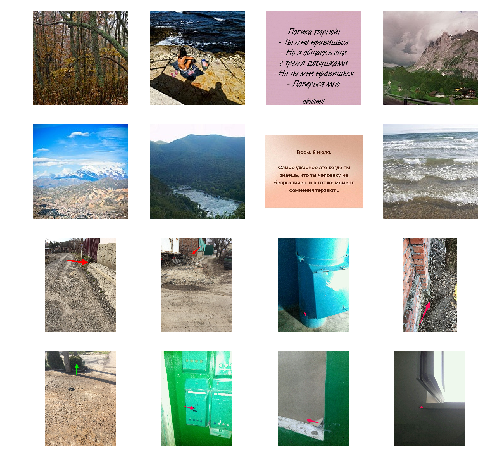

In [7]:
methods.visualize_data(DATA_FOLDER, CATEGORY_1, CATEGORY_2)

## Подготовим данные

In [13]:
image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)


train_generator = train_datagen.flow_from_directory(
        DATA_FOLDER + '/train',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
        DATA_FOLDER + '/validation',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

Found 6202 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Построим и обучим модель 

In [9]:
input_shape = (image_size, image_size, 3)
input_tensor = Input(shape=input_shape)

base_model = tf.keras.applications.MobileNetV2(input_tensor=input_tensor,                                            
                                               include_top=False,
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\keras_applications\mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 103s 11us/step


In [10]:
base_model.trainable = False

In [11]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [12]:
model = tf.keras.Sequential([
  keras.layers.Lambda(lambda x: x, input_shape=input_shape),
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
epochs = 1
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [16]:
history = model.fit_generator(
              train_generator,
              steps_per_epoch = steps_per_epoch,
              epochs = epochs,
              workers = 4,
              validation_data = validation_generator,
              validation_steps = validation_steps)    

Instructions for updating:
Use tf.cast instead.
194/194 [==============================] - 407s 2s/step - loss: 0.5702 - acc: 0.7111 - val_loss: 0.3710 - val_acc: 0.8650


## Fine-tuning 

In [17]:
base_model.trainable = True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [19]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [21]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

194/194 [==============================] - 359s 2s/step - loss: 0.1100 - acc: 0.9736 - val_loss: 0.0464 - val_acc: 0.9830


##  Сохраним результаты

Сохраним модель.

In [22]:
model.save("models/mobileNetV2/mobileNetV2.h5")

In [23]:
saved_model_path = "models/mobileNetV2/"
tf.contrib.saved_model.save_keras_model(model, saved_model_path)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensor

b'models/mobileNetV2/1564031768'

Сохраним историю обучения.

In [24]:
with open("histories/mobileNetV2/mobileNetV2History", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Сохраним историю fine-tuning обучения.

In [25]:
with open("histories/mobileNetV2/mobileNetV2HistoryFine", 'wb') as file_pi:
    pickle.dump(history_fine.history, file_pi)

## Восстановим результаты 

Восстановим модель.

model = keras.models.load_model("models/mobileNetV2/mobileNetV2.h5")

Восстановим модель из .pb

new_model = tf.contrib.saved_model.load_keras_model("models/mobileNetV2/1563965428")
new_model

new_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Восстановим историю обучения.

with open("histories/mobileNetV2/mobileNetV2History", 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

Восстановим историю fine-tuning обучения.

with open("histories/mobileNetV2/mobileNetV2HistoryFine", 'rb') as file_pi:
    history_loaded_fine = pickle.load(file_pi)

## Посмотрим результаты 

Посмотрим графики обучения.

history_loaded = history.history
history_loaded_fine = history_fine.history

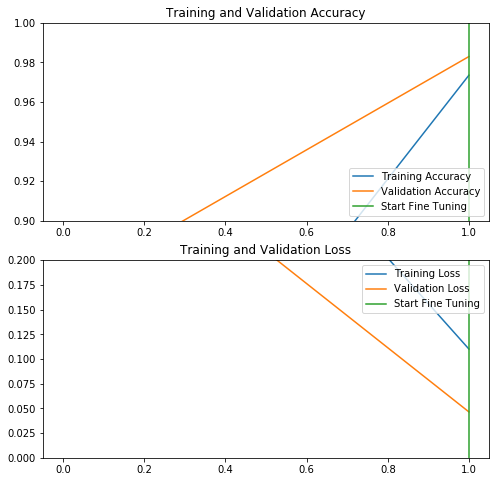

In [5]:
methods.accLossFine(history_loaded, history_loaded_fine)

Оценим параметры модели.

In [9]:
# Calculating accuracy, precision, recall, f1 score.
def AccRecPrec(predictions, test_labels):

    x = tf.placeholder(tf.int32, )
    y = tf.placeholder(tf.int32, )
    acc, acc_op = tf.metrics.accuracy(labels=x, predictions=y)
    rec, rec_op = tf.metrics.recall(labels=x, predictions=y)
    pre, pre_op = tf.metrics.precision(labels=x, predictions=y)
    f1,  f1_op  = tf.contrib.metrics.f1_score(labels=x, predictions=y)

    def f(x):
        if (x>0.5):
            return 1
        else:
            return 0
        
    predictions = np.array(list(map(f, predictions)))

    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    v = sess.run(acc_op, feed_dict={x: test_labels,y: predictions}) # Accuracy.
    r = sess.run(rec_op, feed_dict={x: test_labels,y: predictions}) # Recall.
    p = sess.run(pre_op, feed_dict={x: test_labels,y: predictions}) # Precision.
    f = sess.run(f1_op,  feed_dict={x: test_labels,y: predictions}) # F1.

    print("accuracy: ", v)
    print("recall:   ", r)
    print("precision:", p)
    print("f1:       ", 2*p*r/(p+r))

In [14]:
test_datagen = ImageDataGenerator(rescale = 1/255)
test_generator = test_datagen.flow_from_directory(
        DATA_FOLDER + '/test',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        shuffle=False,
        class_mode = "binary"
)

Found 1000 images belonging to 2 classes.


In [15]:
AccRecPrec(model.predict_generator(test_generator), test_generator.classes)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

accuracy:  0.986
recall:    0.978
precision: 0.99390244
f1:        0.9858871219247495
